In [1]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


The main idea is to ulitize seq2seq, or more specifically encoder-decoder structure. We first encode the image into (num_layer, batch_size, hidden_size), so that the output of the encoder layer can be seen as a hidden state for either LSTM or GRU. For LSTM, the encoder output should be two becuase LSTM has two input (h, c). For GRU we only need one. Considering the running time, complexity and google colab compute units. We are using GRU with single hidden_layer

## Image Captioning Model with Pretrained CNN + GRU

In [2]:
import torch.nn as nn
import torchvision.models as models
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

import collections
import re
import pandas as pd
import random 
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from PIL import Image
from torchvision.transforms import transforms
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


## Data Load and Transform

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Deep_Learning/Image Captioning/Flickr8k/captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
print('total number of unique image: ', len(df['image'].unique()))
print('total number of df: ', len(df))

## plan to use 6091 for training, 1000 for val and 1000 for test

## [0:6091*5 = 30455 ] traing
## [30455:35455,:] val
## [35355: , :] test

total number of unique image:  8091
total number of df:  40455


In [5]:
df_train = df.iloc[:30455, :].reset_index()
df_val = df.iloc[30455:35455,:].reset_index()
df_test= df.iloc[35455:,:].reset_index()

print(len(df_train))
print(len(df_val))
print(len(df_test))

30455
5000
5000


In [6]:
class Vocab:
    def __init__(self, tokens = None, minimum_frequency = 0 , reserved_tokens = None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []

        if len(tokens) == 0 or isinstance(tokens, list):
            tokens = [token for line in tokens for token in line]
            counter = collections.Counter(tokens)
        else:
            raise Exception('tokens should be a list of list')

        self._token_frequence = sorted(counter.items(), key = lambda x: x[1], reverse = True)

        self.index_to_token = ['<UNK>'] + reserved_tokens 
        self.token_to_index = {token: index for index , token in enumerate(self.index_to_token)}

        for token , frequency in self._token_frequence: 
            if frequency < minimum_frequency:
                # because we have already sorted the dictionary in decreasing order
                break

            if token not in self.token_to_index:
                self.index_to_token.append(token)
                self.token_to_index[token] = len(self.index_to_token) - 1

    def __len__(self):
        return len(self.index_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_index.get(tokens, 0) # 0 is the index for <UNK>
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.index_to_token[indices]

        return [self.index_to_token[index] for index in indices]


## Create vocabulary here

In [7]:
tokens = [line.lower().split() for line in df.caption.tolist()]
reserved_tokens = ['<BOS>','<EOS>','<PAD>']
minimum_frequency = 1
vocab = Vocab(tokens,minimum_frequency,reserved_tokens)

In [8]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_path, transform = None, df = None, vocab = None):
        self.image_path = image_path
        self.transform = transform

        self.df = df

        self.img = self.df['image']
        self.caption = self.df['caption']
        self.vocab = vocab
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.img[index]
        caption = self.caption[index]

        image = Image.open(os.path.join(self.image_path, image)).convert('RGB')

        if self.transform != None:
            image = self.transform(image)

        token = caption.lower().split()

        #return image, torch.tensor([self.vocab['<BOS>']] + self.vocab[token] + [self.vocab['<EOS>']])
        return image, torch.tensor( self.vocab[token] + [self.vocab['<EOS>']])

## Create traindata set, validation dataest and test dataset

In [9]:
class Mycollate():
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self,batch):
        images = [i[0].unsqueeze(0) for i in batch] #batch is image and caption -> image = batch[0], caption = batch[1]
        images = torch.cat(images, dim = 0)

        targets = [i[1] for i in batch]
        targets = pad_sequence(targets, batch_first = True, padding_value = self.pad_idx)

        return images, targets

In [10]:
image_path = '/content/gdrive/MyDrive/Deep_Learning/Image Captioning/Flickr8k/Images'
caption_path = "/content/gdrive/MyDrive/Deep_Learning/Image Captioning/Flickr8k/captions.txt"

transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_dataset = Flickr8kDataset(image_path, transform = transform, df = df_train, vocab = vocab)
val_dataset = Flickr8kDataset(image_path, transform = transform,  df = df_val, vocab = vocab )
test_dataset = Flickr8kDataset(image_path, transform = transform, df = df_test, vocab = vocab)

print(len(train_dataset), len(val_dataset), len(test_dataset))

pad_idx = vocab['<PAD>']

train_dataloader = DataLoader(
      dataset = train_dataset,
      batch_size = 32,
      num_workers = 4,
      shuffle = True,
      pin_memory = True,
      collate_fn = Mycollate(pad_idx = pad_idx)
  )

val_dataloader = DataLoader(
      dataset = val_dataset,
      batch_size = 32,
      num_workers = 2,
      pin_memory = True,
      collate_fn = Mycollate(pad_idx = pad_idx)
  )

test_dataloader = DataLoader(
      dataset = test_dataset,
      batch_size = 1,
      num_workers = 2,
      pin_memory = True,
      collate_fn = Mycollate(pad_idx = pad_idx)
  )


30455 5000 5000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model Create CNN and RNN

In [11]:
# resnet18 = torch.hub.load("pytorch/vision", "resnet18", weights="IMAGENET1K_V1")

# here we using pretrained resnet 50
resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [12]:
class encoderCNN(nn.Module):
    ## since we are using the pretrained resnet image input (batch_size, 3, 224, 224)
    ## output size: (hidden_layer = 1, batch_size, hidden_size)
    def __init__(self, hidden_size):
        super(encoderCNN, self).__init__()
        self.resnet = resnet50 #use pretrained resnet50
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        features = self.resnet(x)
        
        # freeze all layers but the FC layer for transfer learning
        for name, param in self.resnet.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        output = self.dropout(self.relu(features)) #[batchsize, hiddensize]

        return output.unsqueeze(0) # [hidden_layer = 1, batchsize, hiddensize]

In [13]:
class decoderRNN(nn.Module): # put encoder into decoder input
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super(decoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + hidden_size, hidden_size, num_layers, dropout = dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, state):
        # X shape [batch_size, sequence_length]
        # state shape [hidden_layer = 1, batch_size, hidden_size]
        
        X = self.embedding(X) #[batch_size, squence_lengh, embed_size]
        X = X.permute(1, 0, 2) # [squence_lengh, batch_size, embed_size]


        input = state.repeat(X.shape[0], 1, 1) #[sequence_length, batch_size, hidden_size]
        X = torch.cat( (X, input), dim = 2 )   # [sequence_length, batch_size, hidden_size + embed_size]
        # Reason: Not only want the encoder output as GRU hidden state, but also concat 
        # the information into input

        output, state = self.rnn(X, state) 
        #output shape: [squence_lengh, batch_size, embed_size]
        #state : shape [num_layer = 1, batchsize, hidden_size]
        
        output = self.linear(output).permute(1, 0, 2)
        #output: [batch_size, squence_lengh, vocab_size]
        
        return output, state


In [14]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers, dropout):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = encoderCNN(hidden_size)
        self.decoderRNN = decoderRNN(vocab_size, embed_size, hidden_size, num_layers, dropout)

    def forward(self, images, caption):
        # images [batchsize, C = 3, H = 224, W = 224]
        # Caption [batchsize, sequence_length]
        # Output [batch_size, squence_lengh, vocab_size]

        encoder_output = self.encoderCNN(images) #[num_layer = 1, batchsize, hidden_size]

        # We concate the <bos> token to the begin of the sentence so that
        # the model will learn how to predict next words start with <bos>
        # this will help us to do further inference

        bos = torch.tensor([vocab['<BOS>']] * caption.shape[0], device = device).reshape(-1,1)
        caption = torch.cat( (bos, caption[:,:-1]), dim = 1)

        output, state = self.decoderRNN(caption, encoder_output)
        return output  

## Model Check Finished

In [15]:
def save_checkpoint(state, filename = "./my_checkpoint2.pth.tar"):
    print("Checkpoint saved")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("Checkpoint loaded")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

In [ ]:
load_model = True
save_model=False

# Model Parameter
embed_size = 256
vocab_size = len(vocab)
hidden_size = 256
num_layers = 1
dropout = 0.5
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers, dropout = dropout).to(device)

# loss and optimazation
learning_rate = 3e-4
loss_criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab["<PAD>"])
optimizer = optim.AdamW(model.parameters(), lr = learning_rate)

# training epochs
num_epochs = 100

print(device)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
def sentence_predict(model, img, vocab, device, max_length):
    with torch.no_grad():
      encoder_output = model.encoderCNN(img) #[1, batchsize, hiddensize]
      X = torch.tensor([vocab['<BOS>']], device = device).unsqueeze(dim = 0)
      #X shape: [1,1] two dimension (start with BOS)

      result = []
      state = encoder_output # [1, batch_size, embed_size]
      
      for _ in range(max_length):
          output, state = model.decoderRNN(X, state) 
          #output shape: [squence_lengh = 1, batch_size = 1, vocab_size]
          #state  shape [num_layer = 1, batchsize, embed_size]
          X = output.argmax(dim = 2) 
          # X shape: [batch_size = 1, sequence_length = 1]
          prediction = X.squeeze(0).item()
          
          if prediction == vocab['<EOS>']:
              break
          
          result.append(prediction)
      
      return ' '.join(vocab.to_tokens(result))

torch.Size([1, 3, 224, 224])
torch.Size([1, 17])
['a', 'dog', 'is', 'jumping', 'over', 'a', 'log', 'in', 'a', 'wooded', 'area', 'while', 'carrying', 'another', 'log', '.', '<EOS>']
flatscreen stylish ragged kneeling sunsets very cooling artists videocameras glowers mess landmark tossing faithful caches hallway seidwalk zip-line descends redheaded fruit laundry girls occasion pensive glide beer baseball waterboard torso-deep


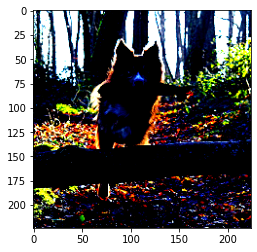

In [ ]:
# (test_image, test_captions) = next(iter(test_dataloader)) 
# test_image = test_image.to(device)
# test_captions = test_captions.to(device)

# print(test_image.shape)
# print(test_captions.shape)

# print(vocab.to_tokens(test_captions[0].tolist()))
# plt.imshow(test_image[0].permute(1,2,0).tolist())

# print(sentence_predict(model, test_image, vocab, device, max_length = 30))


In [ ]:
model.train() 

best_eval_loss = 10000
val_interval = 2

train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    print('epoch: ', epoch+1)
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    save_checkpoint(checkpoint, filename = '/content/gdrive/MyDrive/Deep_Learning/Image Captioning/CNN_GRU.pth.tar')

    total_train_loss = 0
    step = 0

    for idx, (imgs, captions) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False):
        step += 1
        imgs = imgs.to(device)
        captions = captions.to(device)

        output = model(imgs, captions) 
        optimizer.zero_grad()

        # captions shape: [batch_size ,sequence_length]
        # output.shape : [batch_size, sequence_length, vocab_size]
        # loss entropy loss:
            # input: (N, C)
            # output: (N)
        loss = loss_criterion(output.reshape(-1, output.shape[2]), captions.reshape(-1))

        total_train_loss += loss.item()
        
        loss.backward()

        # CLIPPING Method
        clip_grad_norm_(model.parameters(), 5)
        
        optimizer.step()
        
    total_train_loss = total_train_loss / step
    train_loss_list.append(total_train_loss)
    print('Train loss: {}'.format(total_train_loss))
    
    
    ## for inference
    #print(sentence_predict(model, test_image, vocab, device, max_length = 30))

    val_total_loss = 0
    val_step = 0

    if (epoch + 1) % val_interval == 0:
      with torch.no_grad():
        for idx, (imgs, captions) in tqdm(enumerate(val_dataloader), total=len(val_dataloader), leave=False):
          val_step += 1
          imgs = imgs.to(device)
          captions = captions.to(device)

          output = model(imgs, captions) 
          loss = loss_criterion(output.reshape(-1, output.shape[2]), captions.reshape(-1))

          val_total_loss += loss.item()        
          
        val_total_loss = val_total_loss / val_step
        val_loss_list.append(val_total_loss)
        print('val loss: {}'.format(val_total_loss))

      if val_total_loss < best_eval_loss:
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint, filename = '/content/gdrive/MyDrive/Deep_Learning/Image Captioning/CNN_BEST_GRU.pth.tar')



epoch:  1
Checkpoint saved


Train loss: 4.144075731770331
epoch:  2
Checkpoint saved


Train loss: 3.266642532929653


val loss: 3.3237769102594656
Checkpoint saved
epoch:  3
Checkpoint saved


Train loss: 2.9731044305973695
epoch:  4
Checkpoint saved


Train loss: 2.790212145372599


val loss: 3.1042681621138457
Checkpoint saved
epoch:  5
Checkpoint saved


Train loss: 2.653526462927586
epoch:  6
Checkpoint saved


Train loss: 2.5456333370769726


val loss: 3.028904419795723
Checkpoint saved
epoch:  7
Checkpoint saved


Train loss: 2.4546061366045175
epoch:  8
Checkpoint saved


Train loss: 2.376221916880928


val loss: 3.002801705317892
Checkpoint saved
epoch:  9
Checkpoint saved


Train loss: 2.3076843853507722
epoch:  10
Checkpoint saved


Train loss: 2.2444060755377055


val loss: 2.989770787536718
Checkpoint saved
epoch:  11
Checkpoint saved


Train loss: 2.1880488390682125
epoch:  12
Checkpoint saved


Train loss: 2.135736539584248


val loss: 3.0003817035893725
Checkpoint saved
epoch:  13
Checkpoint saved


Train loss: 2.08902423246568
epoch:  14
Checkpoint saved


Train loss: 2.045362091364981


val loss: 3.0119065934685385
Checkpoint saved
epoch:  15
Checkpoint saved


Train loss: 2.001977333626827
epoch:  16
Checkpoint saved


Train loss: 1.9640377672279583


val loss: 3.028634148798171
Checkpoint saved
epoch:  17
Checkpoint saved


Train loss: 1.9276221626195587
epoch:  18
Checkpoint saved


Train loss: 1.8947580449220514


val loss: 3.0523567457867276
Checkpoint saved
epoch:  19
Checkpoint saved


Train loss: 1.8612941061498738
epoch:  20
Checkpoint saved


Train loss: 1.8315636948878025


val loss: 3.0684237844625097
Checkpoint saved
epoch:  21
Checkpoint saved


Train loss: 1.80300628775809
epoch:  22
Checkpoint saved


Train loss: 1.7752993318463575


val loss: 3.086528621661435
Checkpoint saved
epoch:  23
Checkpoint saved


Train loss: 1.7469623593472634
epoch:  24
Checkpoint saved


Train loss: 1.7211216152215205


val loss: 3.104400835219462
Checkpoint saved
epoch:  25
Checkpoint saved


Train loss: 1.6974907163061013
epoch:  26
Checkpoint saved


Train loss: 1.6734807235854012


val loss: 3.130751600690708
Checkpoint saved
epoch:  27
Checkpoint saved


Train loss: 1.6517242542585404
epoch:  28
Checkpoint saved


Train loss: 1.6300564324405014


val loss: 3.1519593008004936
Checkpoint saved
epoch:  29
Checkpoint saved


Train loss: 1.6117343829960382
epoch:  30
Checkpoint saved


Train loss: 1.589182532384616


val loss: 3.1729848293741796
Checkpoint saved
epoch:  31
Checkpoint saved


Train loss: 1.569037657575447
epoch:  32
Checkpoint saved


Train loss: 1.5497877430014249


val loss: 3.1944657025063874
Checkpoint saved
epoch:  33
Checkpoint saved


Train loss: 1.532271284641338
epoch:  34
Checkpoint saved


Train loss: 1.513927205270078


val loss: 3.220991072381378
Checkpoint saved
epoch:  35
Checkpoint saved


Train loss: 1.4982440752141617
epoch:  36
Checkpoint saved


Train loss: 1.482909765564093


val loss: 3.241913564645561
Checkpoint saved
epoch:  37
Checkpoint saved


Train loss: 1.464759504219063
epoch:  38
Checkpoint saved


Train loss: 1.4501523848842173


val loss: 3.2643753328141134
Checkpoint saved
epoch:  39
Checkpoint saved


Train loss: 1.4339184887519403
epoch:  40
Checkpoint saved


Train loss: 1.4204107888606416


val loss: 3.288942074320119
Checkpoint saved
epoch:  41
Checkpoint saved


Train loss: 1.4075367793816478
epoch:  42
Checkpoint saved


Train loss: 1.3920677952906664


val loss: 3.3108532869132463
Checkpoint saved
epoch:  43
Checkpoint saved


Train loss: 1.3799693029718239
epoch:  44
Checkpoint saved


Train loss: 1.3657331231261503


val loss: 3.3362753922772255
Checkpoint saved
epoch:  45
Checkpoint saved


Train loss: 1.3520255608468497
epoch:  46
Checkpoint saved


Train loss: 1.3413585753751402


val loss: 3.3557689022866026
Checkpoint saved
epoch:  47
Checkpoint saved


Train loss: 1.326602971228231
epoch:  48
Checkpoint saved


Train loss: 1.3158612839814996


val loss: 3.377714630904471
Checkpoint saved
epoch:  49
Checkpoint saved


Train loss: 1.3043272953574396
epoch:  50
Checkpoint saved


Train loss: 1.2933850297156502


val loss: 3.40665963349069
Checkpoint saved
epoch:  51
Checkpoint saved


Train loss: 1.2827057850961925
epoch:  52
Checkpoint saved


Train loss: 1.2719691743870742


val loss: 3.4292071837528497
Checkpoint saved
epoch:  53
Checkpoint saved


Train loss: 1.261042706605767
epoch:  54
Checkpoint saved


Train loss: 1.2495423539095567


val loss: 3.4506510442988887
Checkpoint saved
epoch:  55
Checkpoint saved


Train loss: 1.240882828581233
epoch:  56
Checkpoint saved


Train loss: 1.2308722058264148


val loss: 3.4736827285426437
Checkpoint saved
epoch:  57
Checkpoint saved


Train loss: 1.2215820832663224
epoch:  58
Checkpoint saved


Train loss: 1.2121317243876577


val loss: 3.4919417678930196
Checkpoint saved
epoch:  59
Checkpoint saved


Train loss: 1.2047184469068752
epoch:  60
Checkpoint saved


Train loss: 1.1948252057327944


val loss: 3.5114126858437897
Checkpoint saved
epoch:  61
Checkpoint saved


Train loss: 1.1861629377142722
epoch:  62
Checkpoint saved


Train loss: 1.1783840434641397


val loss: 3.5348317683882016
Checkpoint saved
epoch:  63
Checkpoint saved


Train loss: 1.17116452640846
epoch:  64
Checkpoint saved


Train loss: 1.1612352603623848


val loss: 3.5668583538881533
Checkpoint saved
epoch:  65
Checkpoint saved


Train loss: 1.153952934035734
epoch:  66
Checkpoint saved


Train loss: 1.146697143171014


val loss: 3.5795589495616356
Checkpoint saved
epoch:  67
Checkpoint saved


Train loss: 1.136180131250069
epoch:  68
Checkpoint saved


Train loss: 1.1293822430512483


val loss: 3.601454327820213
Checkpoint saved
epoch:  69
Checkpoint saved


Train loss: 1.123497854573887
epoch:  70
Checkpoint saved


Train loss: 1.115005703658617


val loss: 3.620465097913317
Checkpoint saved
epoch:  71
Checkpoint saved


Train loss: 1.1101469114548017
epoch:  72
Checkpoint saved


Train loss: 1.100429656500576


val loss: 3.642940451385109
Checkpoint saved
epoch:  73
Checkpoint saved


Train loss: 1.0938475973465864
epoch:  74
Checkpoint saved


Train loss: 1.0873011778257473


val loss: 3.66907974868823
Checkpoint saved
epoch:  75
Checkpoint saved


Train loss: 1.0809108957397837
epoch:  76
Checkpoint saved


Train loss: 1.0730360940474422


val loss: 3.680375477310958
Checkpoint saved
epoch:  77
Checkpoint saved


Train loss: 1.0678066286970587
epoch:  78
Checkpoint saved


Train loss: 1.0622533633052802


val loss: 3.6995482171417042
Checkpoint saved
epoch:  79
Checkpoint saved


Train loss: 1.053178137778735
epoch:  80
Checkpoint saved


Train loss: 1.0483656718450434


val loss: 3.726764411683295
Checkpoint saved
epoch:  81
Checkpoint saved


Train loss: 1.0442870634944499
epoch:  82
Checkpoint saved


Train loss: 1.038754554105406


val loss: 3.7418249048245182
Checkpoint saved
epoch:  83
Checkpoint saved


Train loss: 1.0316843089311063
epoch:  84
Checkpoint saved


Train loss: 1.0250530627344836


val loss: 3.7639700561572034
Checkpoint saved
epoch:  85
Checkpoint saved


Train loss: 1.0204264592348027
epoch:  86
Checkpoint saved


Train loss: 1.014615955786044


val loss: 3.773670829785098
Checkpoint saved
epoch:  87
Checkpoint saved


Train loss: 1.0094444830628002
epoch:  88
Checkpoint saved


Train loss: 1.00412926647593


val loss: 3.7941289919956476
Checkpoint saved
epoch:  89
Checkpoint saved


Train loss: 0.998676582294352
epoch:  90
Checkpoint saved


Train loss: 0.9944050486097816


val loss: 3.815643919501335
Checkpoint saved
epoch:  91
Checkpoint saved


Train loss: 0.990679876205801
epoch:  92
Checkpoint saved


Train loss: 0.984509778936871


val loss: 3.8298517442812585
Checkpoint saved
epoch:  93
Checkpoint saved


Train loss: 0.978112663791961
epoch:  94
Checkpoint saved


Train loss: 0.9729316810599896


val loss: 3.851557997381611
Checkpoint saved
epoch:  95
Checkpoint saved


Train loss: 0.9706000675674246
epoch:  96
Checkpoint saved


Train loss: 0.9640630648291412


val loss: 3.861440161990512
Checkpoint saved
epoch:  97
Checkpoint saved


Train loss: 0.9577446202395343
epoch:  98
Checkpoint saved


Train loss: 0.9571006605479898


val loss: 3.872468175402113
Checkpoint saved
epoch:  99
Checkpoint saved


Train loss: 0.950751546989469
epoch:  100
Checkpoint saved


Train loss: 0.9478883653753946


val loss: 3.8949643897402817
Checkpoint saved


In [ ]:
with open('/content/gdrive/MyDrive/Deep_Learning/Image Captioning/CNN_GRU_Train.txt', 'a') as testwritefile_train:
  for index, i in enumerate(train_loss_list):
    testwritefile_train.write('step :{}, loss score: {}\n'.format(index,i))

with open('/content/gdrive/MyDrive/Deep_Learning/Image Captioning/CNN_GRU_Val.txt', 'a') as testwritefile_val:
  for index, i in enumerate(val_loss_list):
    testwritefile_val.write('step :{}, loss score: {}\n'.format(index,i))

FileNotFoundError: ignored